<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "PC"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/PC/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


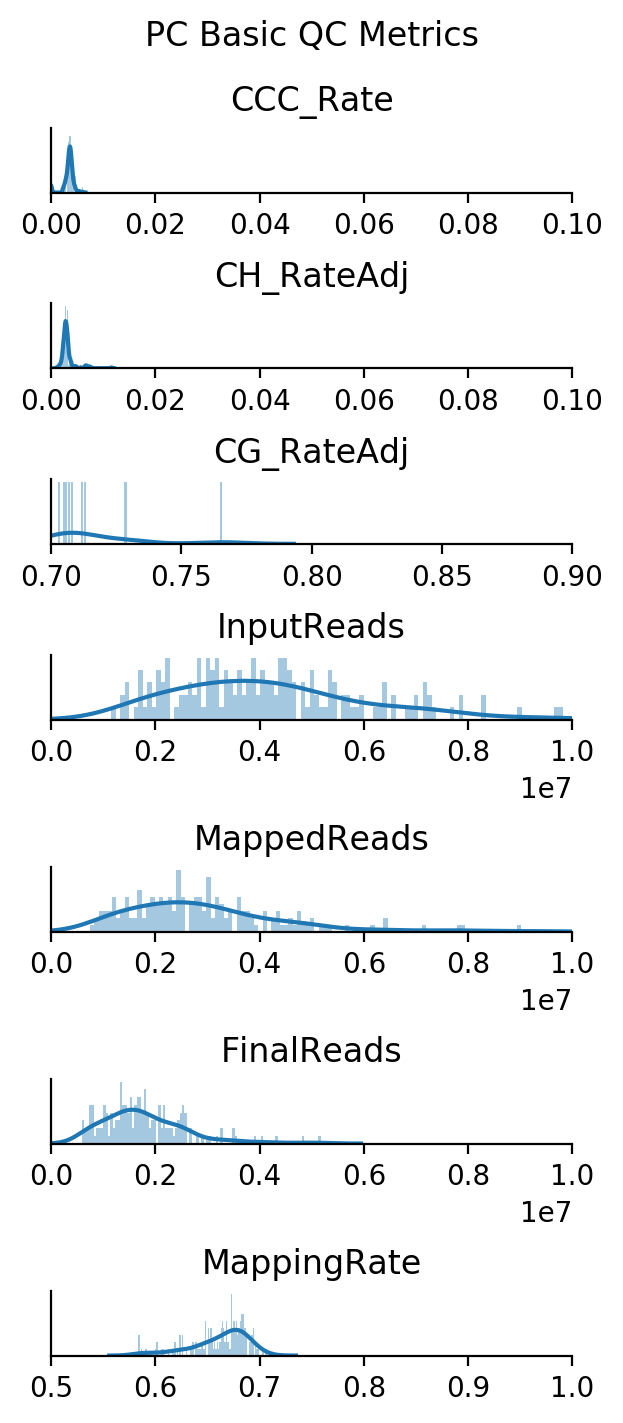

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

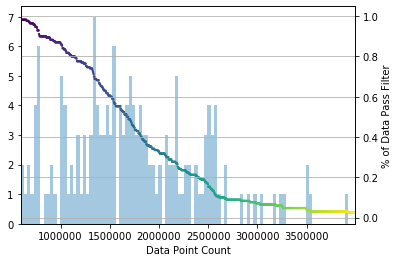

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 170/170 (100.0%)
CG_RateAdj passed 170/170 (100.0%)
CH_RateAdj passed 170/170 (100.0%)
FinalReads passed 170/170 (100.0%)
MappingRate passed 170/170 (100.0%)
Overall passed 170/170 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 1
171207 3
171212 3
171213 2
171214 4
180104 4
180109 2
180110 4
180111 1
180119 2
180123 4
180129 1
180130 1
180206 1
180208 1
180212 2
180213 2
180220 2
180222 1
180226 4
180227 2
180305 2
180312 1
180320 5
180326 2
180329 5
180402 2
180403 5
180405 3
180409 3
180410 1
180412 3
180416 1
180417 4
180419 4
180423 2
180424 3
180430 2
180501 1
180514 3
180529 4
180605 1
180724 1
180806 1
180911 1
180925 2
181002 1
181008 5
181009 2
181015 2
181016 1
181022 4
181023 4
181204 2
181206 2
181210 3
181220 2
190117 6
190122 1
190205 3
190207 1
190214 9
190219 3
190305 2
190625 1
190627 1
190711 1
190716 5


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 29 7.6%
ad002 19 4.9%
ad004 15 3.9%
ad006 17 4.4%
ad007 20 5.2%
ad008 28 7.3%
ad010 22 5.7%
ad012 20 5.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_117,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.003866,0.649548,0.648188,0.006675,0.002820,1647058.0,4158780,2705736.0,10E,...,-26.419163,3.717795,-44.672150,19.819713,PC,7.699460,10.267608,-63.788966,-7.050497,True
10E_M_2834,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003549,0.636819,0.635525,0.006146,0.002606,1618671.0,4590150,2973943.0,10E,...,-26.180973,3.468287,-44.582019,20.038123,PC,8.126525,11.087117,-65.937669,-5.969738,True
11E_M_221,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.004002,0.657492,0.656116,0.007225,0.003235,1326735.0,3325888,2144782.0,11E,...,-26.185205,3.648682,-44.496573,19.976040,PC,7.845943,10.982344,-65.648067,-6.641604,True
11E_M_410,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.003773,0.650584,0.649261,0.006571,0.002809,1520636.0,3812184,2473466.0,11E,...,-26.488783,3.584776,-44.878995,19.839008,PC,7.805117,10.257483,-64.130925,-6.797821,True
11E_M_503,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.003470,0.657885,0.656693,0.006699,0.003240,1502746.0,3632080,2440151.0,11E,...,-25.964592,3.709200,-44.207979,20.062982,PC,7.417654,11.136489,-66.305638,-7.606795,True
11E_M_792,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.003409,0.615774,0.614459,0.006216,0.002816,1900500.0,4822838,3257295.0,11E,...,-26.416908,3.354382,-45.022877,19.934689,PC,8.362420,10.865184,-64.459270,-4.585083,True
11F_M_1167,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.003950,0.638630,0.637197,0.007125,0.003188,1362609.0,3029360,2050146.0,11F,...,-26.146477,3.534979,-44.501129,20.027779,PC,7.862025,10.906490,-65.478516,-6.653431,True
11F_M_1170,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004060,0.624877,0.623348,0.006954,0.002906,1770037.0,4016846,2702039.0,11F,...,-26.662222,3.407925,-45.331465,19.735394,PC,8.451673,10.363136,-63.599778,-5.037613,True
11F_M_1828,/gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...,0.003537,0.627972,0.626652,0.006242,0.002714,890567.0,1723944,1174757.0,11F,...,-26.303375,3.545544,-44.634134,19.973376,PC,8.385968,10.386208,-64.201439,-5.634282,True
